# The data
* Statistics of registered vehicles by Estonian Transport Administration: https://www.mnt.ee/et/ametist/statistika/soidukite-statistika
* Offences detected during traffic supervision by Estonian Police and Border Guard Board: https://avaandmed.eesti.ee/datasets/liiklusjarelevalve-kaigus-avastatud-suuteod

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import chisquare
plt.style.use('lenk_style') # my default plot style

# Data on offences

In [2]:
df_offences = pd.read_csv('road_traffic_offences.csv', sep='\t')
df_offences = df_offences.drop_duplicates()

df_offences.head()

,CaseId,Date,Time,Weekday,Act,Paragraph,ParagraphFull,Section,Clause,Provision,...,Lest_X,Lest_Y,VehicleType,VehicleRegCountry,VehicleBrand,VehicleYear,OffenderGender,OffenderAge,OffenderAddress,OffenceType
0,a8a2a384-ad6c-18d8-809b-f2bfbad78e4c,2020-12-30,22:32,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,lg. 1.,,LS § 16 lg. 1,...,6476000-6476499,660500-660999,SOIDUAUTO,EST,FORD,NaN,M,18-25,NaN,VT
1,a8a2a37a-ad6c-18d8-809b-f2bfbad78e4c,2020-12-30,22:06,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,lg. 1.,,NaN,...,6582000-6582499,694000-694499,SOIDUAUTO,EST,HONDA,2007,M,18-25,NaN,VT
2,a8a2a3c0-ad6c-18d8-809b-f2bfbad78e4c,2020-12-30,21:39,Kolmapäev,Karistusseadustik,§ 424.,§ 424. Mootorsõiduki ja trammi juhtimine joobe...,lg. 2.,,NaN,...,6584500-6584999,541000-541499,SOIDUAUTO,EST,CHRYSLER,2008,M,45-54,NaN,KT
3,a8a2a366-ad6c-18d8-809b-f2bfbad78e4c,2020-12-30,21:20,Kolmapäev,Liiklusseadus,§ 259.,"§ 259. Jalakäija, tasakaaluliikuri juhi, jalgr...",lg. 1.,,LS § 259 lg. 1,...,6588500-6588999,541000-541499,NaN,NaN,NaN,NaN,N,45-54,NaN,VT
4,a8a2a348-ad6c-18d8-809b-f2bfbad78e4c,2020-12-30,21:01,Kolmapäev,Liiklusseadus,§ 259.,"§ 259. Jalakäija, tasakaaluliikuri juhi, jalgr...",lg. 1.,,LS § 25 lg. 3,...,6590000-6590499,539500-539999,NaN,NaN,NaN,NaN,M,26-34,NaN,VT


In [3]:
df_offences = df_offences.dropna(subset=['ParagraphFull', 'VehicleBrand', 'OffenderGender', 'OffenderAge'])

In [4]:
df_offences = df_offences.loc[(df_offences['OffenderGender'].isin(['M','N']))]
df_offences['OffenderGender'] = df_offences['OffenderGender'].map({'M':'male', 'N':'female'})

In [5]:
df_offences['Date'] = pd.to_datetime(df_offences['Date'])

In [6]:
# only including cars and year 2020
df_offences = df_offences.loc[df_offences['VehicleType']=='SOIDUAUTO']
df_offences = df_offences.loc[df_offences['Date'].dt.year==2020]

In [7]:
# categorizing the offences
d = {'joobes|alkohol':'DUI', 'sõidukiirus':'speeding', 'turvavöö':'no seatbelt',
     'foori keelava tule':'red light', 'juhtimisõiguseta':'no licence', 'muu rikkumine':'other', 
     'kontrolli mitteläbinud':'test not passed', 'parkimine':'wrong parking',
     'veoseveo':'carriage req violation', 'registreerimata':'not registered'}

df_offences['offence'] = ''

for i in d:
    df_offences['offence'] = np.where(df_offences['ParagraphFull'].str.contains(i, flags=re.IGNORECASE), 
                                      d[i], df_offences['offence'])
    
df_offences['offence'] = np.where(df_offences['offence']=='', 'miscellaneous', df_offences['offence'])

In [8]:
df_offences['offence'].value_counts()

speeding                  34481
other                      8914
DUI                        5005
red light                  4870
test not passed            3748
no licence                 2990
miscellaneous              1508
no seatbelt                1223
not registered              596
wrong parking               236
carriage req violation      150
Name: offence, dtype: int64

# Data on registered vehicles

In [9]:
df_registry = pd.read_csv('registry.csv')

df_registry.head()

,County,Category,Body,Brand,Model,Color,Fuel combination,Fuel,First registration year,Average vehicle age,Vehicle count
0,Harju maakond,M1,ELAMU,BEDFORD,CF 350,VALGE,YHEKYTUSELINE,DIISEL,1978,43,1
1,Harju maakond,M1,ELAMU,BEDFORD,CF 350,VALGE,YHEKYTUSELINE,DIISEL,1980,41,1
2,Harju maakond,M1,ELAMU,CHALLENGER,GENESIS 32 M06,VALGE,YHEKYTUSELINE,DIISEL,2006,15,1
3,Harju maakond,M1,ELAMU,CHAUSSON TRIGANO,FLASH 26 M11,VALGE,YHEKYTUSELINE,DIISEL,2011,10,1
4,Harju maakond,M1,ELAMU,CHEVROLET,CHEVY VAN 30 JAMBOREE,BEEZ,YHEKYTUSELINE,BENSIIN,1984,37,1


In [10]:
# include only cars
df_registry = df_registry.loc[df_registry['Category'].isin(['M1','M1G'])]

In [11]:
df_registry['Vehicle count'].sum()

822305

In [12]:
df_registry.loc[(df_registry['Brand']=='BMW')&
                (df_registry['Fuel']=='DIISEL')&
                (df_registry['Body']=='UNIVERSAAL')&
                (df_registry['Model']=='530D XDRIVE')&
                (df_registry['Color']=='PRUUN')&
                (df_registry['First registration year']==2014)]

,County,Category,Body,Brand,Model,Color,Fuel combination,Fuel,First registration year,Average vehicle age,Vehicle count
73077,Harju maakond,M1,UNIVERSAAL,BMW,530D XDRIVE,PRUUN,YHEKYTUSELINE,DIISEL,2014,7,3
261250,Pärnu maakond,M1,UNIVERSAAL,BMW,530D XDRIVE,PRUUN,YHEKYTUSELINE,DIISEL,2014,7,1
320025,Saare maakond,M1,UNIVERSAAL,BMW,530D XDRIVE,PRUUN,YHEKYTUSELINE,DIISEL,2014,7,2
361632,Tartu maakond,M1,UNIVERSAAL,BMW,530D XDRIVE,PRUUN,YHEKYTUSELINE,DIISEL,2014,7,1
410466,Viljandi maakond,M1,UNIVERSAAL,BMW,530D XDRIVE,PRUUN,YHEKYTUSELINE,DIISEL,2014,7,1


In [13]:
df_registry.groupby('Brand')[['Vehicle count']].sum().sort_values(by='Vehicle count', ascending=False).head(50)

,Vehicle count
Brand,
VOLKSWAGEN,102436
TOYOTA,66504
AUDI,64680
FORD,57658
BMW,56402
OPEL,44419
MERCEDES-BENZ,43368
VOLVO,41095
SKODA,36621


# Offences per registered cars

In [14]:
all_cars = df_registry.groupby('Brand')[['Vehicle count']].sum().sort_values(by='Vehicle count', ascending=False)
# only including cars that make up about 1% of the total cars registered
all_cars = all_cars.loc[all_cars['Vehicle count']>=8200]
all_cars = all_cars.rename(columns={'Vehicle count':'total_registered'})

In [15]:
offences = df_offences.pivot_table(index='VehicleBrand', columns='offence', 
                                   values='CaseId', aggfunc='count').fillna(0)
offences['total'] = offences.sum(axis=1)

In [16]:
df = pd.concat([all_cars, offences], axis=1)
df = df.dropna()

for col in df.iloc[:,1:].columns:
    df[col] = df[col] / df['total_registered']

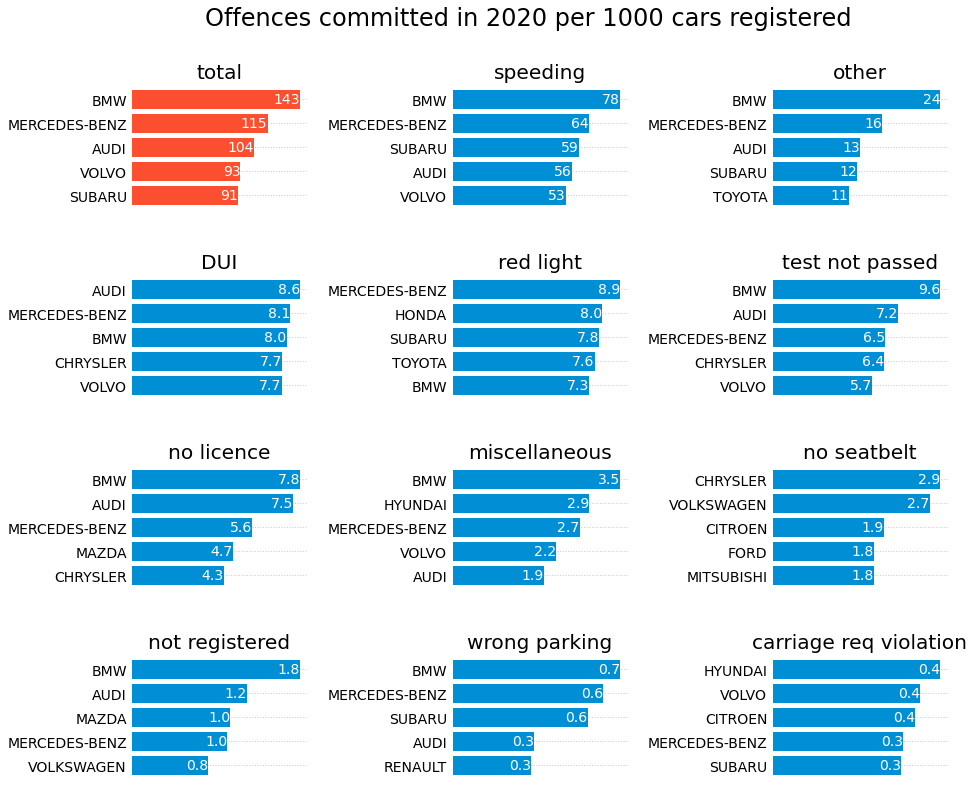

In [17]:
nrows, ncols = 4, 3
num_plots = nrows*ncols
fig = plt.figure(figsize=(12, 10))
axes = [plt.subplot(nrows,ncols,i) for i in range(1,num_plots+1)]

plt.tight_layout(pad=0, w_pad=1, h_pad=1)
plt.subplots_adjust(wspace=.8, hspace=.5)

cols = ['total'] + list(df_offences['offence'].value_counts().index)

for i, c in enumerate(cols):
    width = df[c].sort_values(ascending=False).head().sort_values()
    y = width.index
    
    if c == 'total':
        axes[i].barh(y, width, color='#fc4f30')
    else:
        axes[i].barh(y, width)
    axes[i].set_title(c)
    axes[i].tick_params(bottom=False)
    axes[i].get_xaxis().set_visible(False)
    
    for j, value in enumerate(width):
        if width[j]*1000 > 10:
            axes[i].text(x=width[j], y=j, s=int(round(width[j]*1000)), va='center', ha='right', color='white')
        else:
            axes[i].text(x=width[j], y=j, s=round(width[j]*1000,1), va='center', ha='right', color='white')
        
fig.suptitle('Offences committed in 2020 per 1000 cars registered', y=1.1, size=24)

plt.savefig('offences.png', bbox_inches='tight', dpi=100)

# Age distribution

In [18]:
df_offences['is_bmw'] = np.where(df_offences['VehicleBrand']=='BMW',1,0)

In [19]:
by_age = df_offences.pivot_table(index='OffenderAge', columns='is_bmw',
                                 values='CaseId', aggfunc='count')
by_age = by_age / by_age.sum(axis=0) * 100
by_age

is_bmw,0,1
OffenderAge,,
13-15,0.127524,0.124301
16-17,0.414900,0.671224
18-25,12.084201,33.871970
26-34,23.446368,29.919204
35-44,25.826209,19.080174
45-54,20.691142,10.677439
55-64,12.788275,4.487259
65-,4.621381,1.168428


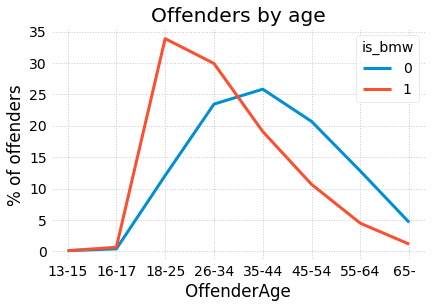

In [20]:
by_age.plot()
plt.title('Offenders by age')
plt.ylabel('% of offenders')
plt.show()

In [21]:
observed = by_age[1]
expected = by_age[0]
dof = 7
chi_square, p_value = chisquare(f_obs=observed, f_exp=expected, ddof=len(observed) - 1 - dof)

print(f'χ² is {chi_square}, p-value is {p_value}')

if p_value > 0.05:
    print('At alpha = 0.05, this is not statistically significant.')
else:
    print('At alpha = 0.05, this is statistically significant.')

χ² is 55.80524409962038, p-value is 1.0322783542993562e-09
At alpha = 0.05, this is statistically significant.


# Gender distribution

In [22]:
by_gender = df_offences.pivot_table(index='OffenderGender', columns='is_bmw',
                                 values='CaseId', aggfunc='count')
by_gender = by_gender / by_gender.sum(axis=0) * 100
by_gender

is_bmw,0,1
OffenderGender,,
female,21.477836,16.693599
male,78.522164,83.306401


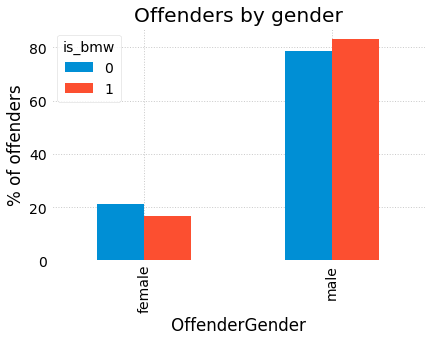

In [23]:
by_gender.plot(kind='bar')
plt.title('Offenders by gender')
plt.ylabel('% of offenders')
plt.show()

In [24]:
observed = by_gender[1]
expected = by_gender[0]
dof = 1
chi_square, p_value = chisquare(f_obs=observed, f_exp=expected, ddof=len(observed) - 1 - dof)

print(f'χ² is {chi_square}, p-value is {p_value}')

if p_value > 0.05:
    print('At alpha = 0.05, this is not statistically significant.')
else:
    print('At alpha = 0.05, this is statistically significant.')

χ² is 1.3571963625381884, p-value is 0.2440239679908205
At alpha = 0.05, this is not statistically significant.
